# TAGUP DATA ENGINEERING TAKE HOME CHALLENGE 
## By TzuHwan Seet

In [2]:
# import libraries
import pandas as pd
import sqlite3
from functools import reduce
import numpy as np
import xarray as xr
from scipy import stats

In [3]:
def read_feature_table_into_df(num_features=0, file_path="data/exampleco_db.db", static_data=False):
    """
    read feature tables from db and convert them into dataframes
    param num_features: number of feature tables to read
    param file_path: file path to db
    return: a list of dfs converted from tables
    """
    # create connection
    con = sqlite3.connect(file_path)
    if static_data:
        df = pd.read_sql_query(f"SELECT * FROM static_data", con)
        con.close()
        return df
    else:
        df_list = []
        for i in range(num_features):
            df = pd.read_sql_query(f"SELECT * FROM feat_{i}", con)
            df.name = f"feature_{i}"
            df_list.append(df)
        con.close()
        return df_list

dfs = read_feature_table_into_df(num_features=4)


In [4]:
dfs[0].head()

,timestamp,machine,value
0,2019-01-01 00:00:00.000000000,machine_0,12.626096
1,2019-01-01 08:00:09.603201067,machine_0,10.831994
2,2019-01-01 16:00:19.206402134,machine_0,21.083510
3,2019-01-02 00:00:28.809603201,machine_0,32.294495
4,2019-01-02 08:00:38.412804268,machine_0,28.057100


In [5]:
# Helper methods for data checking and cleaning
def check_number_of_machines(df):
    n = len(df.machine.unique())
    print(f"This table has {n} machines")

def check_null_values(df):
    assert df.isnull().sum().sum() == 0, "there are null values in df"
   
def check_column_types(df):
    assert df.dtypes["timestamp"] == "datetime64[ns]", "timestamp column is not datetime"
    assert df.dtypes["machine"] == "int64", "machine column is not int"
    assert df.dtypes[df.name] == "float64", "machine column is not float"
    
def convert_to_datetime(df):
    # check if column exists
    if "timestamp" not in df:
        raise ValueError("dataframe doesn't have timestamp column")
    df.timestamp = pd.to_datetime(df.timestamp, infer_datetime_format=True)

# remove "machine_" from machine column
def remove_machine_label(df):
    # check if column exists
    if "machine" not in df:
        raise ValueError("dataframe doesn't have machine column")
    df.machine = df.apply(lambda x: x.machine.split("_")[-1], axis=1)
    df.machine = pd.to_numeric(df.machine)

def rename_value_column(df):
    df.rename(columns={"value": df.name}, inplace=True)

# wrapper function for the tests
def clean_df(df_list):
    for df in df_list:
        print(f"~~~Checking dataframe of table {df.name}~~~")
        check_number_of_machines(df)
        check_null_values(df)
        convert_to_datetime(df)
        remove_machine_label(df)
        rename_value_column(df)
        check_column_types(df)


In [6]:
clean_df(dfs)

~~~Checking dataframe of table feature_0~~~
This table has 20 machines
~~~Checking dataframe of table feature_1~~~
This table has 20 machines
~~~Checking dataframe of table feature_2~~~
This table has 20 machines
~~~Checking dataframe of table feature_3~~~
This table has 20 machines


In [7]:
# Join all dfs 
combined_df = reduce(lambda left,right: pd.merge(left,right,on=["timestamp", "machine"]), dfs)

combined_df

,timestamp,machine,feature_0,feature_1,feature_2,feature_3
0,2019-01-01 00:00:00.000000000,0,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,0,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,0,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,0,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,0,28.057100,3.691359,21.984744,13.670561
...,...,...,...,...,...,...
59995,2021-09-25 15:59:21.587195728,19,0.002403,0.013519,0.002612,0.005599
59996,2021-09-25 23:59:31.190396800,19,0.023516,-0.004443,0.011515,0.009060
59997,2021-09-26 07:59:40.793597872,19,0.002002,-0.008331,-0.002329,-0.005856
59998,2021-09-26 15:59:50.396798944,19,-0.004232,-0.011988,-0.003764,-0.005268


## Removing Outliers 
- Visualizing the distribution of the 4 feature values for each machine suggests that the values are approximately normally distributed.
- With the normal distribution assumption I define an outlier as a value that is more than 3 standard deviations from the mean. However removing outlier rows would make reshaping the array into a shape suitable for ML pipeline challenging. 
- An alternative is to apply sklearn.robustScaler that removes the median and scales the data according the quantile range. 

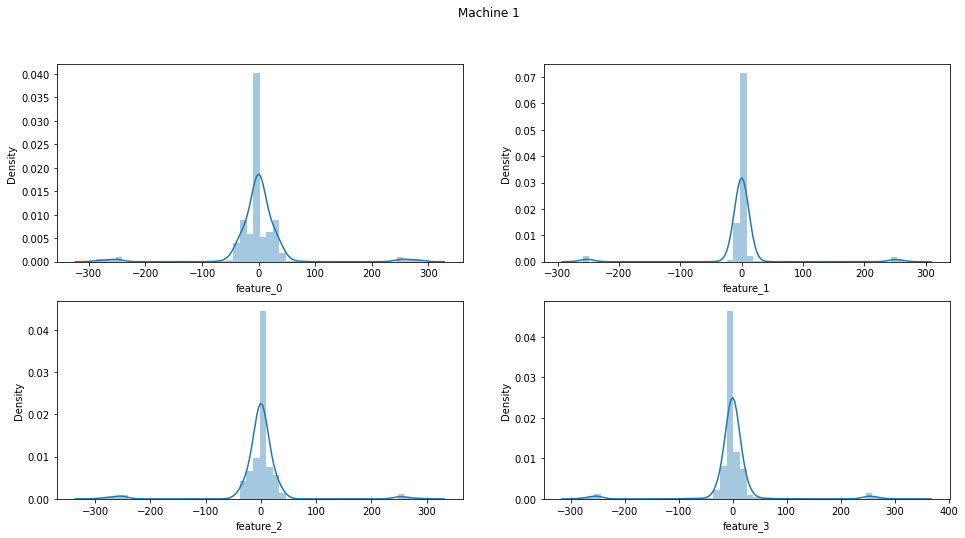

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Visualizing the distribution plot of machine_id=1
machine_no = 1
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_0"])
plt.subplot(2,2,2)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_1"])
plt.subplot(2,2,3)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_2"])
plt.subplot(2,2,4)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_3"])
plt.suptitle("Machine 1")
plt.show()

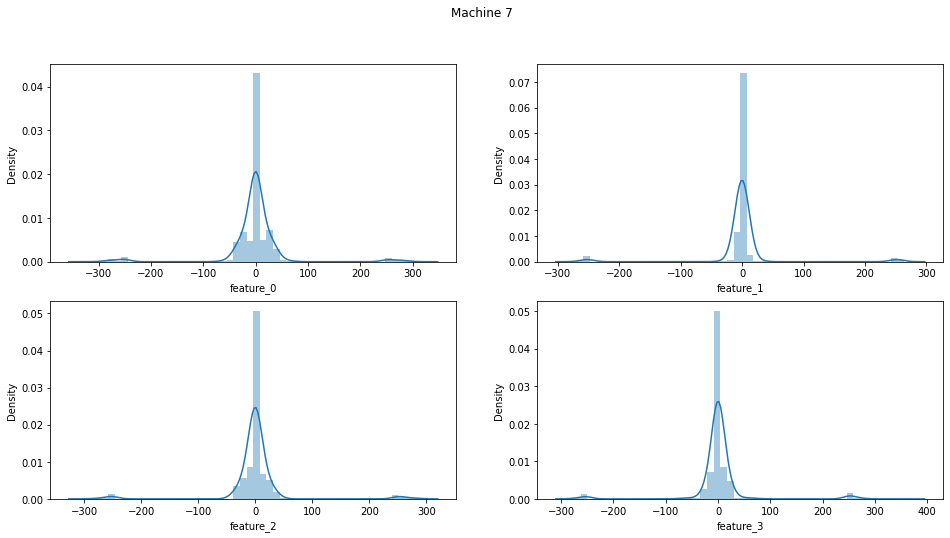

In [9]:
# Visualizing the distribution plot of machine_id=7
machine_no = 7
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_0"])
plt.subplot(2,2,2)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_1"])
plt.subplot(2,2,3)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_2"])
plt.subplot(2,2,4)
sns.distplot(combined_df[combined_df.machine==machine_no]["feature_3"])
plt.suptitle("Machine 7")
plt.show()

### Option 1: Removing values that are greater than 3 standard deviation from mean

**Result**
- The final output has a mean significantly closer to 0, and the variance is signicantly smaller
- Removing rows creates challenges for the subsequent data transformation step. Replacing the outlier values with 3*standard deviation may be a better option.


In [10]:
# remove the outlier rows associated with each 4 features for each machines 
filtered_df = pd.DataFrame()
for i in range(20):
    machine_df = combined_df[combined_df.machine==i]
    z_scores = stats.zscore(machine_df[["feature_0", "feature_1", "feature_2", "feature_3"]])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    outlier_pct = (~filtered_entries).sum()/len(filtered_entries)
    machine_df = machine_df[filtered_entries]
    filtered_df = filtered_df.append(machine_df)

In [11]:
print("Before removing outliers")
print(combined_df[combined_df.machine==7].describe())
print("After removing outliers")
print(filtered_df[filtered_df.machine==7].describe())

Before removing outliers
       machine    feature_0    feature_1    feature_2    feature_3
count   3000.0  3000.000000  3000.000000  3000.000000  3000.000000
mean       7.0    -0.407498    -0.109949     0.300411     1.930839
std        0.0    61.010261    55.696517    57.535965    57.774384
min        7.0  -319.992744  -269.286952  -292.442903  -275.334298
25%        7.0    -0.461305    -0.242026    -1.152536    -0.029348
50%        7.0    -0.000344    -0.000184    -0.000248     0.000289
75%        7.0     1.192487     0.135678     0.350956     0.762235
max        7.0   310.721517   263.399610   285.202304   359.939478
After removing outliers
       machine    feature_0    feature_1    feature_2    feature_3
count   2462.0  2462.000000  2462.000000  2462.000000  2462.000000
mean       7.0    -0.058519     0.025819     0.034378     0.223546
std        0.0    18.265917     4.935374    13.025386    13.169668
min        7.0   -77.141126   -36.479024   -44.237782   -75.949506
25%        7.

### Option 2: IQR Robust Scaler Transform

**Result**
- The median values are now zero and the standard deviation values are now close to 1.0.
- It is possible to adjust the quantile range to improve performance. Wider range allows fewer values to be considered outliers, vice-versa.


In [12]:
# Alternative method that uses the median and the interquartile range 
from sklearn.preprocessing import RobustScaler

def apply_robust_scaler(series):
    transformer = RobustScaler().fit(series.values.reshape(-1,1))
    l = np.squeeze(transformer.transform(series.values.reshape(-1,1)))
    return l

for i in range(20):
    for j in range(4):
        l = apply_robust_scaler(combined_df[combined_df.machine==i][f"feature_{j}"])
        combined_df.loc[combined_df.machine==i, f"feature_{j}"] = l

combined_df[combined_df.machine==7].describe()

,machine,feature_0,feature_1,feature_2,feature_3
count,3000.0,3.000000e+03,3000.000000,3000.000000,3.000000e+03
mean,7.0,-2.461942e-01,-0.290611,0.199974,2.438847e+00
std,0.0,3.689113e+01,147.460796,38.268213,7.298586e+01
min,7.0,-1.934901e+02,-712.957345,-194.508911,-3.478277e+02
25%,7.0,-2.787300e-01,-0.640295,-0.766408,-3.744039e-02
50%,7.0,1.609363e-20,0.000000,0.000000,-3.388132e-20
75%,7.0,7.212700e-01,0.359705,0.233592,9.625596e-01
max,7.0,1.878845e+02,697.371134,189.693388,4.547080e+02


## Adding Static Data
To add the static data associated with each machine, I joined the static table and the dataframe transformed by IQR robust scalar.

In [14]:
# Adding static data to combined_df
static_df = read_feature_table_into_df(static_data=True)

static_df.rename(columns={"machine_id": "machine"}, inplace=True)
# make sure that machine id matches
remove_machine_label(static_df)

static_df.head()


,machine,install_date,model,room
0,0,2019-01-01,Model A,Room 123
1,1,2019-01-01,Model A,Room 123
2,2,2019-01-01,Model A,Room 123
3,3,2019-01-01,Model A,Room 123
4,4,2019-01-01,Model A,Room 123


In [17]:
#join filtered_df and static_df
final_df = pd.merge(combined_df,static_df,on=["machine"], how='left')

final_df.head()

,timestamp,machine,feature_0,feature_1,feature_2,feature_3,install_date,model,room
0,2019-01-01 00:00:00.000000000,0,764.533280,511.124764,-681.432252,608.640584,2019-01-01,Model A,Room 123
1,2019-01-01 08:00:09.603201067,0,655.900555,163.524287,666.674824,1321.415231,2019-01-01,Model A,Room 123
2,2019-01-01 16:00:19.206402134,0,1276.628895,-39.049651,-1029.363412,-81.444636,2019-01-01,Model A,Room 123
3,2019-01-02 00:00:28.809603201,0,1955.452977,378.861991,-778.910198,-256.590466,2019-01-01,Model A,Room 123
4,2019-01-02 08:00:38.412804268,0,1698.879098,214.329694,1268.486364,825.124706,2019-01-01,Model A,Room 123


## Transforming DF into Array
- I decided to convert the final df into a numpy array of shape(number of machines, number of timestamp, number of features(sensor features + static features))
- This format allows the ML model to receive batches of machine data. Assuming that maintaining the continuity of the time series of each machine is important, it is reasonable that each slice of the 3D array is time vs. feature values.  

In [21]:
machine_no = len(final_df.machine.unique())
timestamp_no = len(final_df.timestamp.unique())
column_no = len(final_df.columns)

final_array = final_df.values.reshape(machine_no,timestamp_no,column_no)

final_array.shape

(20, 3000, 9)

In [22]:
# Save numpy array
np.save("machine-features", final_array)